In [1]:
import os
import re
import regex
import feather
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
from datetime import datetime
from dateutil import tz
import dateparser
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import seaborn as sns
# import emoji
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [2]:
def startsWithDateAndTime(pattern, s):
    result = re.match(pattern, s)
    
    if result:
        return True
    return False

In [3]:
def getDataPoint(line):
    
    if startsWithDateAndTime(pattern_kkt, line) == True: # Pattern KakaoTalk
        splitLine = line.split(', ')
        dateTime = splitLine[0]
        splitDateTime = dateTime.split(' à ')
    elif startsWithDateAndTime(pattern_wa, line) == True: # Pattern WhatsApp
        splitLine = line.split(' - ')
        dateTime = splitLine[0]
        splitDateTime = dateTime.split(', ')
        
    # Split, then convert, then concatenate, or it will invert day and month, and return None if > 12
    dt = datetime.combine(
        dateparser.parse(splitDateTime[0]).date(), dateparser.parse(splitDateTime[1]).time()
    )
    
    # Timezones
    vn = tz.gettz('Asia/Ho_Chi_Minh')
    fr = tz.gettz('Europe/Paris')
    
    dt_vn = dt.replace(tzinfo=vn)
    dt_fr = dt_vn.astimezone(tz=fr)
        
    date_vn = dt_vn.strftime("%Y-%m-%d")
    date_fr = dt_fr.strftime("%Y-%m-%d")

    vn_time_12 = dt_vn.strftime("%I:%M %p")
    vn_time_24 = dt_vn.strftime("%H:%M")

    fr_time = dt_fr.strftime("%H:%M")
    
    message = splitLine[1]
    
    if startsWithDateAndTime(pattern_kkt, line) == True: # Pattern KakaoTalk
        splitMessage = message.split(" :", 1) # Only on 1st occurence
    elif startsWithDateAndTime(pattern_wa, line) == True: # Pattern WhatsApp
        splitMessage = message.split(":", 1) # Only on 1st occurence
    
    author = splitMessage[0]
    
    if (author == 'Sulli') or (author == '하린🌸'):
        author = '윤주'
    else:
        author = 'Maxence'
        
    message = splitMessage[1].strip()
        
    return date_vn, date_fr, vn_time_12, vn_time_24, fr_time, author, message

In [4]:
for filename in os.path.join('kakaotalk'):
    if filename.endswith(".txt"):
        with open(os.path.join('kakaotalk', filename), encoding="utf-8") as old, open(os.path.join('kakaotalk_archives/updated_files', filename), 'w', encoding="utf-8") as new:
            lines = old.readlines()
            new.writelines(lines[5:]) # Delete first 5 lines
        continue
    else:
        continue

with open(os.path.join('whatsapp', 'WhatsApp_Chat.txt'), encoding="utf-8") as old, open(os.path.join('whatsapp', 'WhatsApp_Chat_new.txt'), 'w', encoding="utf-8") as new:
    lines = old.readlines()
    new.writelines(lines[1:]) # Delete first line

In [5]:
file_list = []
file_list.append('whatsapp/WhatsApp_Chat_new.txt')

for filename in os.listdir('kakaotalk/updated_files'):
    file_list.append('kakaotalk/updated_files/' + filename)
    
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

# Sorting the list, human order
file_list.sort(key = natural_keys)

In [6]:
pattern_kkt = '^([0-9]+.)(\ )([0-9]+.)(\ )([0-9]+.)(\ à )([0-9]+):([0-9]+)(\ )(AM|PM|am|pm)(\,)'
pattern_wa  = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+)(\, )([0-9]+):([0-9]+)(\ -)'

In [7]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe

pbar = tqdm(file_list) # Progress bar

for file in pbar: # Iterate through the list that contains file paths
    with open(file, 'r', encoding='utf-8') as f:
        messageBuffer = [] 
        date_vn, date_fr, vn_time_12, vn_time_24, fr_time, author = None, None, None, None, None, None

        while True:
            line = f.readline() 

            if not line: 
                break

            line = line.strip() # Trim

            if startsWithDateAndTime(pattern_kkt, line) or startsWithDateAndTime(pattern_wa, line): 
                if len(messageBuffer) > 0: 
                    parsedData.append(
                        [date_vn, date_fr, vn_time_12, vn_time_24, fr_time, author, ' '.join(messageBuffer)]
                    )
                messageBuffer.clear() 
                date_vn, date_fr, vn_time_12, vn_time_24, fr_time, author, message = getDataPoint(line) 
                messageBuffer.append(message) 
            else:
                messageBuffer.append(line)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:31<00:00, 24.64s/it]


In [8]:
df = pd.DataFrame(
    parsedData, 
    columns=['date_vn', 'date_fr', 'vn_time_12', 'vn_time_24', 'fr_time', 'author', 'message']
) # Building the dataframe

In [9]:
# Parsing datetime
df["date_vn"] = pd.to_datetime(df["date_vn"])
df["date_fr"] = pd.to_datetime(df["date_fr"])

In [10]:
# Sort by date and time (bc WA and KKT msg are mixed)
df = df.sort_values(['date_fr', 'fr_time'], ascending=[True, True])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160582 entries, 148497 to 136689
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date_vn     160572 non-null  datetime64[ns]
 1   date_fr     160572 non-null  datetime64[ns]
 2   vn_time_12  160572 non-null  object        
 3   vn_time_24  160572 non-null  object        
 4   fr_time     160572 non-null  object        
 5   author      160572 non-null  object        
 6   message     160582 non-null  object        
dtypes: datetime64[ns](2), object(5)
memory usage: 9.8+ MB


In [12]:
df[df['date_vn'].isna()]

,date_vn,date_fr,vn_time_12,vn_time_24,fr_time,author,message
0,NaT,NaT,None,None,None,None,vendredi 4 décembre 2020
13849,NaT,NaT,None,None,None,None,mercredi 3 février 2021
28605,NaT,NaT,None,None,None,None,jeudi 4 mars 2021
44027,NaT,NaT,None,None,None,None,jeudi 25 mars 2021
60336,NaT,NaT,None,None,None,None,lundi 12 avril 2021
74807,NaT,NaT,None,None,None,None,samedi 1 mai 2021
89647,NaT,NaT,None,None,None,None,samedi 22 mai 2021
104174,NaT,NaT,None,None,None,None,dimanche 6 juin 2021
120330,NaT,NaT,None,None,None,None,mercredi 23 juin 2021
136689,NaT,NaT,None,None,None,None,mercredi 7 juillet 2021


In [13]:
df = df.dropna().reset_index(drop=True)

In [14]:
df

,date_vn,date_fr,vn_time_12,vn_time_24,fr_time,author,message
0,2020-10-06,2020-10-06,07:11 PM,19:11,14:11,윤주,Heyyy
1,2020-10-06,2020-10-06,07:11 PM,19:11,14:11,윤주,Got youu
2,2020-10-06,2020-10-06,07:12 PM,19:12,14:12,Maxence,Hello you!
3,2020-10-06,2020-10-06,07:16 PM,19:16,14:16,윤주,<Media omitted>
4,2020-10-06,2020-10-06,07:16 PM,19:16,14:16,윤주,Hoho
...,...,...,...,...,...,...,...
160567,2021-07-18,2021-07-18,03:47 PM,15:47,10:47,Maxence,Photo
160568,2021-07-18,2021-07-18,03:51 PM,15:51,10:51,Maxence,Photo
160569,2021-07-18,2021-07-18,03:56 PM,15:56,10:56,Maxence,Photo
160570,2021-07-18,2021-07-18,04:08 PM,16:08,11:08,윤주,8 photos


In [15]:
# Save as feather file
feather.write_dataframe(df, 'data.feather')

In [16]:
df = feather.read_dataframe('data.feather')

In [17]:
def get_sec(s):
    l = list(map(int, s.split(':')))
    return sum(n * sec for n, sec in zip(l[::-1], (1, 60, 3600)))

In [18]:
# Calls duration
def sum_call_duration(pattern):
    
    sum_duration = 0

    for i in range(df.shape[0]):
        msg = df['message'][i]
        result = re.match(pattern, msg)

        if result:
            sum_duration = sum_duration + get_sec((re.split(' ', msg)[2])) # time
    
    return sum_duration

In [19]:
def get_is_weekend(x):
    if x.weekday() >= 5:
        return "Y"
    return "N"

df['is_weekend_vn'] = df['date_vn'].apply(get_is_weekend)
df['is_weekend_fr'] = df['date_fr'].apply(get_is_weekend)

In [20]:
days_arr = ["Mon","Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

def get_day_of_week(x):
    return days_arr[x.weekday()]

df['day_of_week_vn'] = df['date_vn'].apply(get_day_of_week)
df['day_of_week_fr'] = df['date_fr'].apply(get_day_of_week)

In [21]:
def get_hour(s):
    return(int(s.split(":")[0]))

df['hour_vn'] = df['vn_time_24'].apply(get_hour)
df['hour_fr'] = df['fr_time'].apply(get_hour)

In [22]:
def get_month(x):
    return int(x.month)

df['month'] = df['date_fr'].apply(get_month)

In [23]:
df

,date_vn,date_fr,vn_time_12,vn_time_24,fr_time,author,message,is_weekend_vn,is_weekend_fr,day_of_week_vn,day_of_week_fr,hour_vn,hour_fr,month
0,2020-10-06,2020-10-06,07:11 PM,19:11,14:11,윤주,Heyyy,N,N,Tue,Tue,19,14,10
1,2020-10-06,2020-10-06,07:11 PM,19:11,14:11,윤주,Got youu,N,N,Tue,Tue,19,14,10
2,2020-10-06,2020-10-06,07:12 PM,19:12,14:12,Maxence,Hello you!,N,N,Tue,Tue,19,14,10
3,2020-10-06,2020-10-06,07:16 PM,19:16,14:16,윤주,<Media omitted>,N,N,Tue,Tue,19,14,10
4,2020-10-06,2020-10-06,07:16 PM,19:16,14:16,윤주,Hoho,N,N,Tue,Tue,19,14,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160567,2021-07-18,2021-07-18,03:47 PM,15:47,10:47,Maxence,Photo,Y,Y,Sun,Sun,15,10,7
160568,2021-07-18,2021-07-18,03:51 PM,15:51,10:51,Maxence,Photo,Y,Y,Sun,Sun,15,10,7
160569,2021-07-18,2021-07-18,03:56 PM,15:56,10:56,Maxence,Photo,Y,Y,Sun,Sun,15,10,7
160570,2021-07-18,2021-07-18,04:08 PM,16:08,11:08,윤주,8 photos,Y,Y,Sun,Sun,16,11,7


In [24]:
print(df.author.unique()) # Authors

['윤주' 'Maxence']


In [25]:
nb_messages = df.shape[0]
print(nb_messages) # Number of messages

160572


In [26]:
nb_photos = 0
nb_media_wa = 0

for i in range(df.shape[0]):
    msg = df['message'][i]
    
    pattern = '^([0-9]+)(\ photo( |s))$|^Photo$'
    result = re.match(pattern, msg)
    
    if result:
        if re.split(' ', msg)[0] == 'Photo': # Case of 1 photo
            nb_photos = nb_photos + 1
        else: # Case of several photos
            nb_photos = nb_photos + int(re.split(' ', msg)[0])
    
    if msg == '<Media omitted>':
        nb_media_wa = nb_media_wa + 1

print(nb_photos, " images or photos via Kakatoalk")
print(nb_media_wa, " messages including medias via WhatsApp")

5043  images or photos via Kakatoalk
348  messages including medias via WhatsApp


In [27]:
print(df[df.message == "Vidéo"].shape[0], " videos sent on KakaoTalk")

89  videos sent on KakaoTalk


In [28]:
print(df[df.message == "Mémo vocal"].shape[0], " voice messages on KakaoTalk")

383  voice messages on KakaoTalk


In [29]:
print(df[df.message == "Emoticons"].shape[0], " KakaoTalk emotes")

2502  KakaoTalk emotes


In [30]:
calls_duration = sum_call_duration('^(Appel (vocal|vidéo))(\ )([0-9]+):([0-9]+)(:[0-9]\d)?$')

print("{:.2f}".format(calls_duration / (60 * 60 * 24)), " days")
print("{:.2f}".format(calls_duration / (60 * 60)), " hours")
print("{:.2f}".format(calls_duration / 60), " minutes")

videocall_duration = sum_call_duration('^(Appel vidéo)(\ )([0-9]+):([0-9]+)(:[0-9]\d)?$')

print("{:.2f}".format(videocall_duration / (60 * 60)), " hours")

13.71  days
328.95  hours
19736.97  minutes
40.01  hours


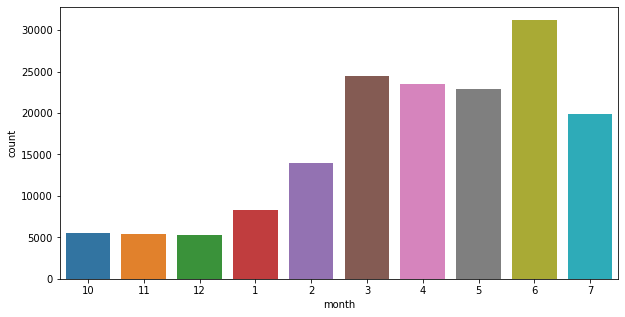

In [31]:
# Messages count by month
plt.figure(figsize = (10, 5))
sns.countplot(x="month", data=df, order=[10, 11, 12, 1, 2, 3, 4, 5, 6, 7]);

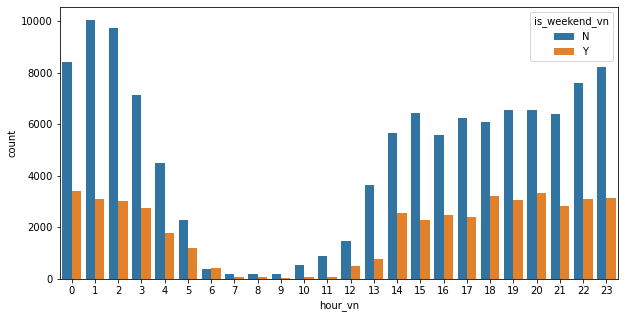

In [32]:
# Messages count by hour (WE or not) in Vietnam
plt.figure(figsize = (10, 5))
sns.countplot(x="hour_vn", hue="is_weekend_vn", data=df);

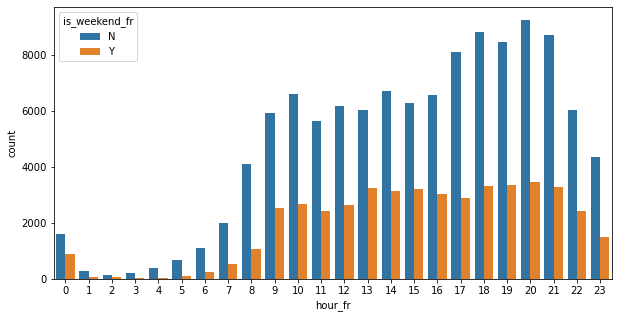

In [33]:
# Messages count by hour (WE or not) in France
plt.figure(figsize = (10, 5))
sns.countplot(x="hour_fr", hue="is_weekend_fr", data=df);

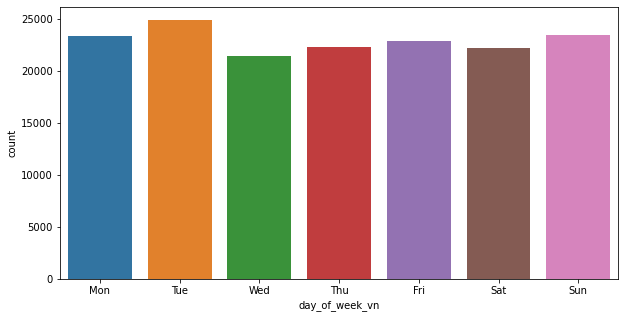

In [34]:
# Messages count by day of week in Vietnam
plt.figure(figsize = (10, 5))
sns.countplot(x="day_of_week_vn", data=df, order=days_arr);

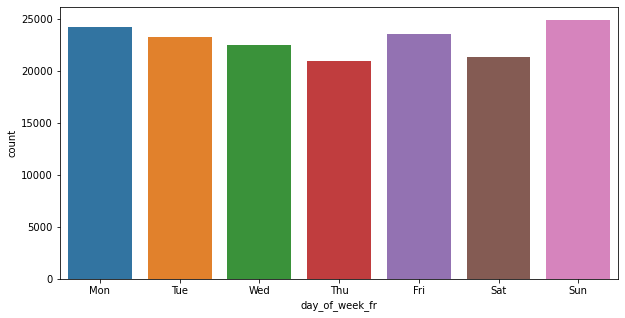

In [35]:
# Messages count by day of week in France
plt.figure(figsize = (10, 5))
sns.countplot(x="day_of_week_fr", data=df, order=days_arr);

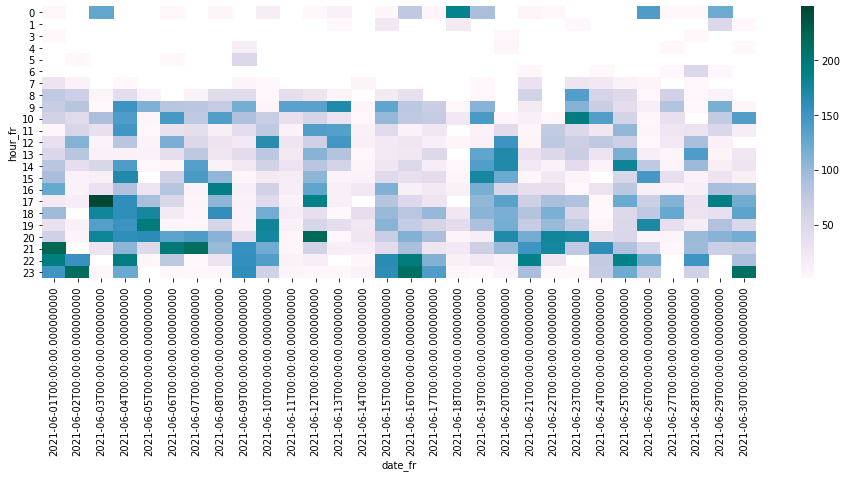

In [36]:
# Heatmap messages count by day and hour in June
df_new = df.loc[df['month'] == 6].groupby(["hour_fr", "date_fr"])["message"].count()
df_new = df_new.reset_index(name="count")

plt.figure(figsize = (16, 5))
sns.heatmap(df_new.pivot("hour_fr", "date_fr", "count"), annot=False, cmap="PuBuGn");

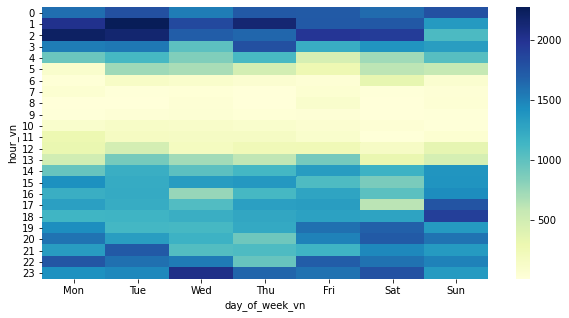

In [37]:
# Heatmap messages count by day of week and hour (Vietnam)
df_heat_vn = df.groupby(["hour_vn", "day_of_week_vn"])["message"].size().reset_index()
df_heat2_vn = df_heat_vn.pivot("hour_vn", "day_of_week_vn", "message")

plt.figure(figsize = (10, 5))
sns.heatmap(df_heat2_vn[days_arr] , cmap="YlGnBu");

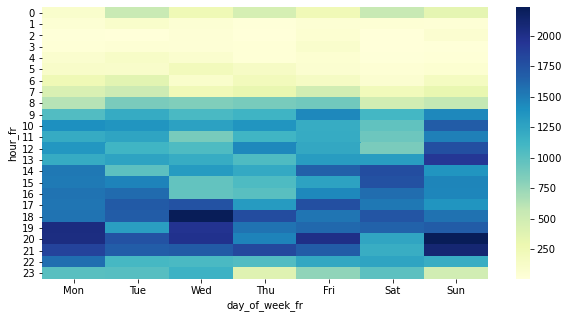

In [38]:
# Heatmap messages count by day of week and hour (France)
df_heat_fr = df.groupby(["hour_fr", "day_of_week_fr"])["message"].size().reset_index()
df_heat2_fr = df_heat_fr.pivot("hour_fr", "day_of_week_fr", "message")

plt.figure(figsize = (10, 5))
sns.heatmap(df_heat2_fr[days_arr] , cmap="YlGnBu");

There are 3841798 words in all the messages.


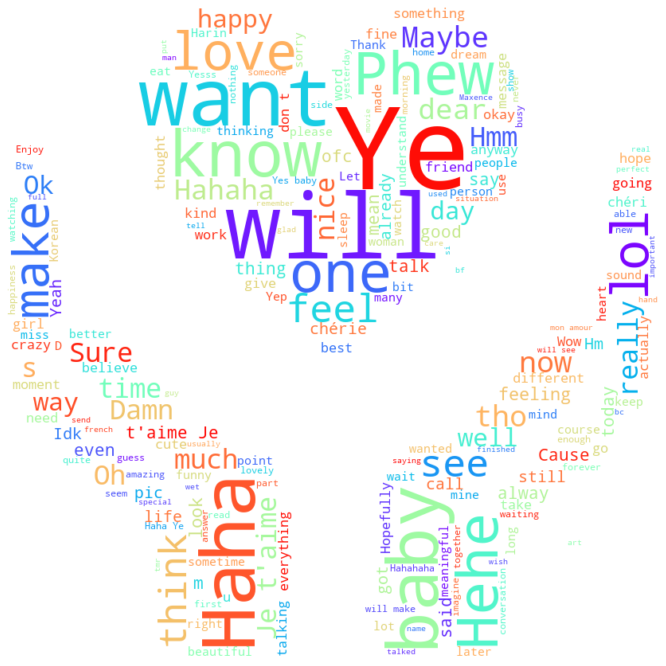

In [39]:
text = " ".join(review for review in df.message)
print("There are {} words in all the messages.".format(len(text)))
stopwords = set(STOPWORDS)

# Adding stopwords from txt file
more_stopwords = [x.strip() for x in open('stopwords.txt', 'r', encoding="utf-8").read().split('\n')]
stopwords = stopwords.union(more_stopwords)

pic = imread('img/heart_mask.jpg')

# Generate a word cloud image
wordcloud = WordCloud(
    mask=pic, stopwords=stopwords, width=1600, height=800, background_color='White', colormap='rainbow'
).generate(text)

plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

윤주 

There are 1797632 words in all the messages.
Average of words sent by 윤주: 22.44


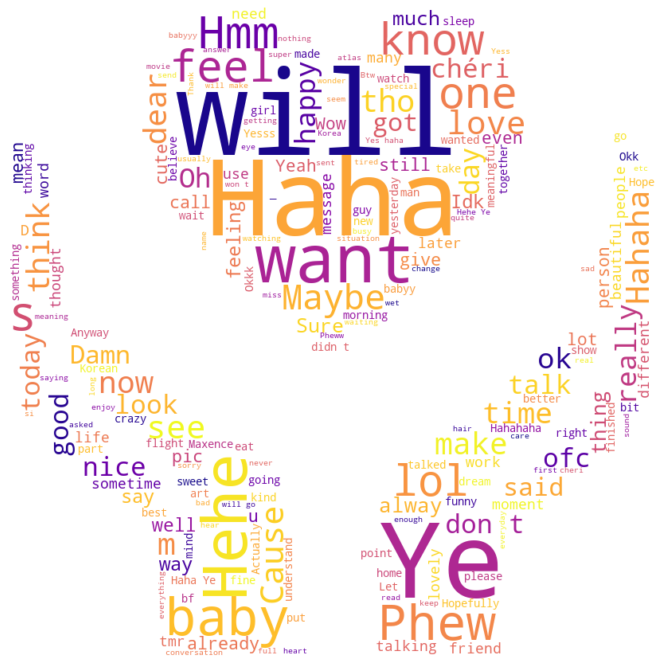

Maxence 

There are 2044165 words in all the messages.
Average of words sent by Maxence: 25.41


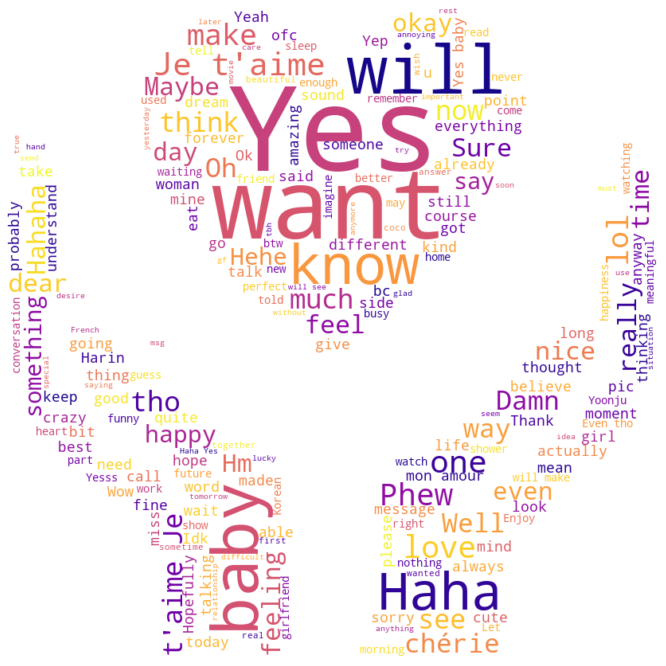

In [40]:
# Wordclous per author
l = df.author.unique()
for i in l:
    author_df = df[df['author'] == i]
    text = " ".join(review for review in author_df.message)
    
    # Author name
    print(i, "\n")
    
    print(
        "There are {} words in all the messages.\nAverage of words sent by {}: {:.2f}"
        .format(len(text), i, len(text)/author_df.shape[0])
    )

    pic = imread('img/heart_mask.jpg')

    # Generate a word cloud image
    wordcloud = WordCloud(
        mask=pic, stopwords=stopwords, width=1600, height=800, background_color='White', colormap='plasma'
    ).generate(text)

    plt.figure(figsize=(24, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()